gofasta vs amanual mutation calling

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO
import numpy as np

In [2]:
pd.set_option('display.max_rows', 200)
pd.set_option("display.max_columns", None)


In [3]:
hu1_gf_dir = '/home/yutianc/bjorn_rep/output/Hu1/gf_Hu1/'
hu1_mm_dir = '/home/yutianc/bjorn_rep/output/Hu1/mm/'
ba1_gf_dir = '/home/yutianc/bjorn_rep/output/Hu1/gf_BA1/'
ba2_gf_dir = '/home/yutianc/bjorn_rep/output/Hu1/gf_BA2/'


pb2_old_dir = '/home/yutianc/bjorn_rep/data/PB2-DMS/'
pb2_gf_dir = '/home/yutianc/bjorn_rep/output/PB2/gf_PP/'
pb2_mm_dir = '/home/yutianc/bjorn_rep/output/PB2/mm/'

cy_gf_dir = '/home/yutianc/bjorn_rep/output/PB2/gf_CY/'
cy_mm_dir = '/home/yutianc/bjorn_rep/output/PB2/mm/'


In [4]:
ambiguous_nuc = ['R', 'Y', 'W', 'S', 'K', 'M', 'B', 'D', 'H', 'V', 'N']

In [5]:
def process(path, common_set):
    df = pd.read_csv(path, sep="\t")
    if common_set:
        df_filtered = df.copy()
        df_filtered = df_filtered.loc[(df_filtered["sra"].isin(common_set)), :]

        return df, df_filtered
    else:
        return df, None


In [6]:
def corr_plt(standard, manual, title):

    standard_grp = (
        standard[~standard["alt"].str.upper().isin(ambiguous_nuc)]
        .groupby("sra")["pos"]
        .nunique()
        .reset_index(name="pos_count_standard")
    )

    manual_grp = (
        manual[~manual["alt"].str.upper().isin(ambiguous_nuc)]
        .groupby("sra")["pos"]
        .nunique()
        .reset_index(name="pos_count_manual")
    )
    
    merged2 = pd.merge(standard_grp, manual_grp, on='sra', how="outer").fillna(0)

    plt.scatter(merged2['pos_count_manual'], merged2['pos_count_standard'], color='lightblue')
    minv = min(merged2['pos_count_manual'])
    maxv = max(merged2['pos_count_manual'])
    
    plt.plot([minv, maxv], [minv, maxv], 'r--', label='y = x')
    plt.legend(loc='upper right')
    plt.xlabel("pos count - our mutation calling")
    plt.ylabel("pos count - standard")
    plt.title(f"Number of mutations in each position, excluding ambiguous nuc for ALT - {title}")
    plt.tight_layout()
    plt.show()

    return merged2[merged2['pos_count_standard'] != merged2['pos_count_manual']]


In [7]:
def get_common_seqs(fa1, fa2):
    seq1 = {rec.id: str(rec.seq).upper() for rec in SeqIO.parse(fa1, "fasta")}
    seq2 = {rec.id: str(rec.seq).upper() for rec in SeqIO.parse(fa2, "fasta")}
    common_ids = set(seq1.keys()) & set(seq2.keys())
    
    return [i for i in common_ids if seq1[i] == seq2[i]]

## Hu1-BA

100.0 % sequences in the alignment files are identical.


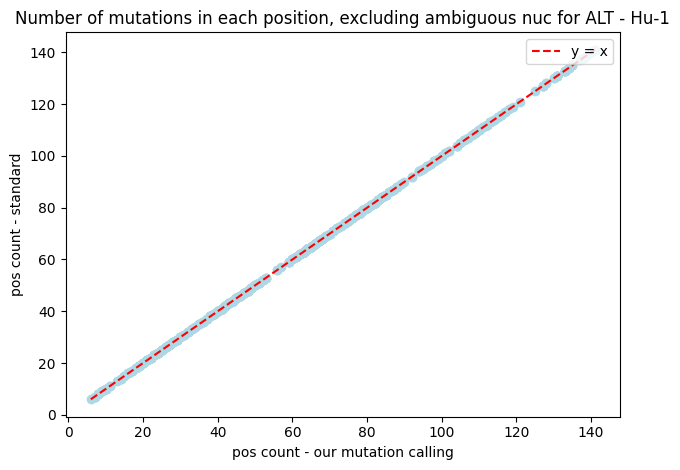

,sra,pos_count_standard,pos_count_manual,gap


In [8]:
common_set = get_common_seqs(hu1_gf_dir+"alignment.fasta", hu1_mm_dir+"alignment.fasta")

hu1_gf, hu1_gf_filtered = process(hu1_gf_dir+"mutations.tsv", common_set)
hu1_mm, hu1_mm_filtered = process(hu1_mm_dir+"mutations.tsv", common_set)

print(round(len(hu1_mm_filtered)/len(hu1_mm), 2)*100, "% sequences in the alignment files are identical.")

pos_mismatch = corr_plt(hu1_gf_filtered, hu1_mm_filtered, "Hu-1")
pos_mismatch["gap"] = pos_mismatch["pos_count_manual"] - pos_mismatch["pos_count_standard"]
pos_mismatch.sort_values(by=["gap"], ascending=False)

In [13]:
tmp1 = (hu1_gf[~hu1_gf["alt"].isin(ambiguous_nuc)]
        .drop(columns=["ref_codon", "alt_codon"])
        .sort_values(by=["sra", "pos", "GFF_FEATURE"])
        .reset_index(drop=True)
)

hu1_mm.loc[(hu1_mm["ref_aa"] == "X") | (hu1_mm["alt_aa"] == "X"), ["GFF_FEATURE", "ref_aa", "alt_aa", "pos_aa"]] = np.nan
tmp2 = (hu1_mm[~hu1_mm["alt"].isin(ambiguous_nuc)]
        .drop(columns=["ref_codon", "alt_codon"])
        .sort_values(by=["sra", "pos", "GFF_FEATURE"])
        .drop_duplicates() # duplicaed from replacing GFF with nan
        .reset_index(drop=True)
)
tmp2 = tmp2.drop_duplicates().reset_index(drop=True)

tmp1.compare(tmp2, keep_equal=True)



Empty DataFrame
Columns: []
Index: []

92.0 % sequences in the alignment files are identical.


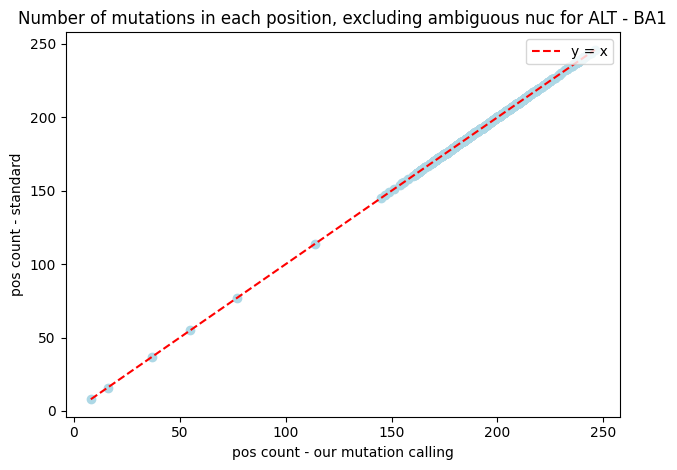

,sra,pos_count_standard,pos_count_manual,gap


In [14]:
common_set = get_common_seqs(ba1_gf_dir+"alignment.fasta", hu1_mm_dir+"alignment.fasta")

ba1_gf, ba1_gf_filtered = process(ba1_gf_dir+"mutations.tsv", common_set)
ba1_mm, ba1_mm_filtered = process(hu1_mm_dir+"NC_045512.2_BA.1_mutations.tsv", common_set)


print(round(len(ba1_mm_filtered)/len(ba1_mm), 2)*100, "% sequences in the alignment files are identical.")

pos_mismatch = corr_plt(ba1_gf_filtered, ba1_mm_filtered, "BA1")
pos_mismatch["gap"] = pos_mismatch["pos_count_manual"] - pos_mismatch["pos_count_standard"]
pos_mismatch.sort_values(by=["gap"], ascending=False)

In [15]:
tmp1 = (ba1_gf_filtered[~ba1_gf_filtered["alt"].isin(ambiguous_nuc)]
        .drop(columns=["ref_codon", "alt_codon"])
        .sort_values(by=["sra", "pos", "GFF_FEATURE"])
        .reset_index(drop=True)
)

ba1_mm_filtered.loc[(ba1_mm_filtered["ref_aa"] == "X") | (ba1_mm_filtered["alt_aa"] == "X"), ["GFF_FEATURE", "ref_aa", "alt_aa", "pos_aa"]] = np.nan
tmp2 = (ba1_mm_filtered[~ba1_mm_filtered["alt"].isin(ambiguous_nuc)]
        .drop(columns=["ref_codon", "alt_codon"])
        .sort_values(by=["sra", "pos", "GFF_FEATURE"])
        .drop_duplicates()
        .reset_index(drop=True)
)

print(len(tmp1))
print(len(tmp2))
tmp1.compare(tmp2, keep_equal=True)

175515
175515


Empty DataFrame
Columns: []
Index: []

100.0 % sequences in the alignment files are identical.


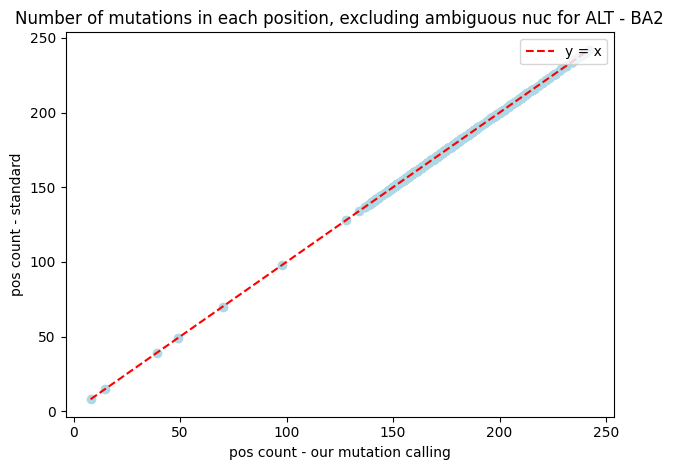

,sra,pos_count_standard,pos_count_manual,gap


In [16]:
common_set = get_common_seqs(ba2_gf_dir+"alignment.fasta", hu1_mm_dir+"alignment.fasta")

ba2_gf, ba2_gf_filtered = process(ba2_gf_dir+"mutations.tsv", common_set)
ba2_mm, ba2_mm_filtered = process(hu1_mm_dir+"NC_045512.2_BA.2_mutations.tsv", common_set)

print(round(len(ba2_mm_filtered)/len(ba2_mm), 2)*100, "% sequences in the alignment files are identical.")

pos_mismatch = corr_plt(ba2_gf_filtered, ba2_mm_filtered, "BA2")
pos_mismatch["gap"] = pos_mismatch["pos_count_manual"] - pos_mismatch["pos_count_standard"]
pos_mismatch.sort_values(by=["gap"], ascending=False)


In [18]:
tmp1 = (ba2_gf[~ba2_gf["alt"].isin(ambiguous_nuc)]
        .drop(columns=["ref_codon", "alt_codon"]) # drop these 2 cols since gofasta does not output ref and alt codon when using "gofasta variants" (not "gofasta sam variants")
        .sort_values(by=["sra", "pos", "GFF_FEATURE"])
        .reset_index(drop=True)
)

ba2_mm.loc[(ba2_mm["ref_aa"] == "X") | (ba2_mm["alt_aa"] == "X"), ["GFF_FEATURE", "ref_aa", "alt_aa", "pos_aa"]] = np.nan
tmp2 = (ba2_mm[~ba2_mm["alt"].isin(ambiguous_nuc)]
        .drop(columns=["ref_codon", "alt_codon"])
        .sort_values(by=["sra", "pos", "GFF_FEATURE"])
        .drop_duplicates()
        .reset_index(drop=True)
)

print(len(tmp1))
print(len(tmp2))
tmp1.compare(tmp2, keep_equal=True)

179588
179588


Empty DataFrame
Columns: []
Index: []

## PB2 - DMS

100.0 % sequences in the alignment files are identical.


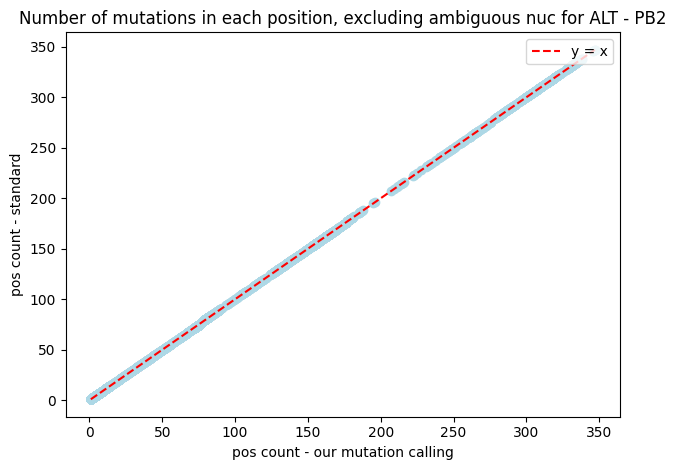

,sra,pos_count_standard,pos_count_manual,gap


In [19]:
common_set = get_common_seqs(pb2_gf_dir+"alignment.fasta", pb2_mm_dir+"alignment.fasta")

pb2_gf, pb2_gf_filtered = process(pb2_gf_dir+"mutations.tsv", common_set)
pb2_mm, pb2_mm_filtered = process(pb2_mm_dir+"mutations.tsv", common_set)

print(round(len(pb2_mm_filtered)/len(pb2_mm), 2)*100, "% sequences in the alignment files are identical.")

pos_mismatch = corr_plt(pb2_gf_filtered, pb2_mm_filtered, "PB2")
pos_mismatch["gap"] = pos_mismatch["pos_count_manual"] - pos_mismatch["pos_count_standard"]
pos_mismatch.sort_values(by=["gap"], ascending=False)


In [20]:
tmp1 = (pb2_gf[~pb2_gf["alt"].isin(ambiguous_nuc) ]
        .drop(columns=["ref_codon", "alt_codon"])
        .sort_values(by=["sra", "pos", "GFF_FEATURE"])
        .reset_index(drop=True)
)


pb2_mm.loc[(pb2_mm["ref_aa"] == "X") | (pb2_mm["alt_aa"] == "X"), ["GFF_FEATURE", "ref_aa", "alt_aa", "pos_aa"]] = np.nan
tmp2 = (pb2_mm[~pb2_mm["alt"].isin(ambiguous_nuc)]
        .drop(columns=["ref_codon", "alt_codon"])
        .sort_values(by=["sra", "pos", "GFF_FEATURE"])
        .drop_duplicates()
        .reset_index(drop=True)
)

print(len(tmp1))
print(len(tmp2))

tmp1.compare(tmp2, keep_equal=True)


854076
854076


Empty DataFrame
Columns: []
Index: []

In [ ]:
# new data came in, this comparision is not effective.

# pb2_old, _ = process(pb2_old_dir+"mutations.tsv", None)
# pb2_mm, _ = process(pb2_mm_dir+"mutations.tsv", None)
# pb2_mm["sra"] = pb2_mm["sra"].apply(lambda x: x.split('_')[1])

# pos_mismatch = corr_plt(pb2_old, pb2_mm, "PB2 (old mut)")
# pos_mismatch["gap"] = pos_mismatch["pos_count_manual"] - pos_mismatch["pos_count_standard"]
# pos_mismatch.sort_values(by=["gap"], ascending=False)


In [ ]:
# tmp1 = (pb2_old[(~pb2_old["alt"].isin(ambiguous_nuc)) & (~pb2_old["alt"].str.startswith("+"))] # ins from gofasta sam variants??
#         .drop(columns=["ref_codon", "alt_codon"])
#         .sort_values(by=["sra", "pos", "GFF_FEATURE"])
#         .reset_index(drop=True)
# )
# tmp2 = (pb2_mm[~pb2_mm["alt"].isin(ambiguous_nuc)]
#         .drop(columns=["ref_codon", "alt_codon"])
#         .sort_values(by=["sra", "pos", "GFF_FEATURE"])
#         .reset_index(drop=True)
# )

# tmp1.compare(tmp2, keep_equal=True)

96.0 % sequences are identical.


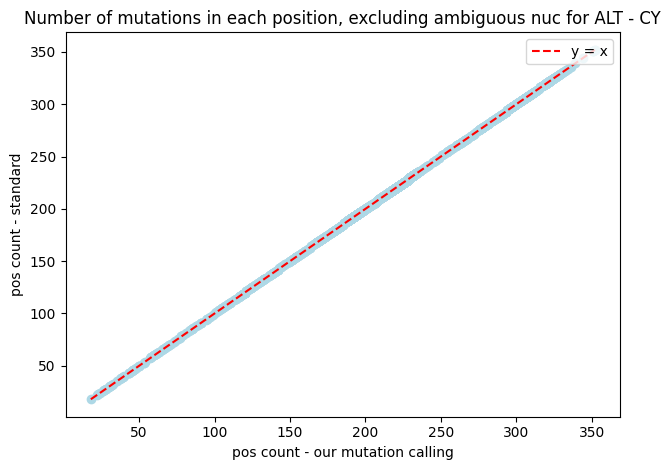

,sra,pos_count_standard,pos_count_manual,gap


In [8]:
common_set = get_common_seqs(cy_gf_dir+"alignment.fasta", cy_mm_dir+"alignment.fasta")

cy_mm, cy_mm_filtered = process(cy_mm_dir+"CY018884.1_cds_ABM21959.1_1_mutations.tsv", common_set)
cy_mm_filtered["sra"] = cy_mm_filtered["sra"].apply(lambda x: x.split('_')[1])
cy_gf, cy_gf_filtered = process(cy_gf_dir+"mutations.tsv", common_set)
cy_gf_filtered["sra"] = cy_gf_filtered["sra"].apply(lambda x: x.split('_')[1])

print(round(len(cy_mm_filtered)/len(cy_mm), 2)*100, "% sequences are identical.")

pos_mismatch = corr_plt(cy_gf_filtered, cy_mm_filtered, "CY")
pos_mismatch["gap"] = pos_mismatch["pos_count_manual"] - pos_mismatch["pos_count_standard"]
pos_mismatch = pos_mismatch.sort_values(by=["gap"], ascending=False)

pos_mismatch

In [23]:
tmp1.loc[(tmp1["GFF_FEATURE"] == "XAJ25426.1") & (tmp1["ref_aa"] == "V") & (tmp1["alt_aa"] == "I") & (tmp1["pos_aa"] == 649), :]

,sra,region,pos,ref,alt,GFF_FEATURE,ref_aa,alt_aa,pos_aa
8126,SRR24839088,PB2,1945,G,A,XAJ25426.1,V,I,649.0
8127,SRR24839088,PB2,1947,A,T,XAJ25426.1,V,I,649.0
32903,SRR24839202,PB2,1945,G,A,XAJ25426.1,V,I,649.0
32904,SRR24839202,PB2,1947,A,T,XAJ25426.1,V,I,649.0
296041,SRR28752446,PB2,1945,G,A,XAJ25426.1,V,I,649.0
...,...,...,...,...,...,...,...,...,...
2843499,SRR36212338,PB2,1945,G,A,XAJ25426.1,V,I,649.0
2854886,SRR36212395,PB2,1945,G,A,XAJ25426.1,V,I,649.0
2870725,SRR36212478,PB2,1945,G,A,XAJ25426.1,V,I,649.0
2871173,SRR36212480,PB2,1945,G,A,XAJ25426.1,V,I,649.0


In [24]:
tmp2.loc[(tmp2["sra"] == "SRR24839088") & (tmp2["pos"] == 1945), :]

,sra,region,pos,ref,alt,GFF_FEATURE,ref_aa,alt_aa,pos_aa
8126,SRR24839088,PB2,1945,G,A,XAJ25426.1,V,I,649.0


In [9]:
tmp1 = (cy_gf_filtered[~cy_gf_filtered["alt"].isin(ambiguous_nuc)]
        .drop(columns=["ref_codon", "alt_codon"])
        .sort_values(by=["sra", "pos", "GFF_FEATURE"])
        .reset_index(drop=True)
)

cy_mm_filtered.loc[(cy_mm_filtered["ref_aa"] == "X") | (cy_mm_filtered["alt_aa"] == "X"), ["GFF_FEATURE", "ref_aa", "alt_aa", "pos_aa"]] = np.nan
tmp2 = (cy_mm_filtered[~cy_mm_filtered["alt"].isin(ambiguous_nuc)]
        .drop(columns=["ref_codon", "alt_codon"])
        .sort_values(by=["sra", "pos", "GFF_FEATURE"])
        .drop_duplicates()
        .reset_index(drop=True)
)

tmp1.compare(tmp2, keep_equal=True)

Empty DataFrame
Columns: []
Index: []

In [28]:
import itertools

IUPAC = {
    "R": ["A","G"],
    "Y": ["C","T"],
    "S": ["G","C"],
    "W": ["A","T"],
    "K": ["G","T"],
    "M": ["A","C"],
    "B": ["C","G","T"],
    "D": ["A","G","T"],
    "H": ["A","C","T"],
    "V": ["A","C","G"],
    "N": ["A","C","G","T"],
    "-": ["-"],
}

def expand_base(b):
    if b in "ACGT":
        return [b]
    else:
        return IUPAC[b]
    
def translate(codon):
    try:
        return str(Seq("".join(codon)).translate(table=1))
    except:
        return "X"

def get_possible_aas(codon):
    codon = codon.upper()
    possibilities = itertools.product(
        expand_base(codon[0]),
        expand_base(codon[1]),
        expand_base(codon[2]),
    )
    return {translate(p) for p in possibilities}

def consensus_aa(codon):
    aas = get_possible_aas(codon)
    return next(iter(aas)) if len(aas) == 1 else "X"

consensus_aa(np.nan)

AttributeError: 'float' object has no attribute 'upper'

In [ ]:
f = list(SeqIO.parse("/home/yutianc/bjorn_rep/data/PB2-DMS/PB2_samples/SRR33319052_PB2_cns.fa", "fasta"))
count = f[0].seq.count('-')+f[0].seq.count('N')
print(count/len(f[0].seq)*100)

In [ ]:
tmp1 = cy_gf.loc[(cy_gf["sra"] == "SRR33319052") & (~cy_gf["alt"].isin(ambiguous_nuc)), :]
tmp2 = cy_mm.loc[(cy_mm["sra"] == "SRR33319052") & (~cy_mm["alt"].isin(ambiguous_nuc)), :]
m = pd.merge(tmp1, tmp2, how="outer", indicator=True, on=["sra", "pos"])
m[m["_merge"]!="both"]

In [ ]:
combined_fasta = list(SeqIO.parse('/home/yutianc/bjorn_rep/output/Hu1/gf_BA2/combined.fasta', "fasta"))
combined_fasta_ls = [rec.id for rec in combined_fasta]

alignment_fasta = list(SeqIO.parse('/home/yutianc/bjorn_rep/output/Hu1/gf_BA2/alignment.fasta', "fasta"))
alignment_fasta_ls = [rec.id for rec in alignment_fasta]

list(set(combined_fasta_ls) - set(alignment_fasta_ls))

In [ ]:
# combined_fasta = list(SeqIO.parse('/home/yutianc/bjorn_rep/output/Hu1/gf_BA2/combined.fasta', "fasta"))
# combined_fasta_ls = [rec.id for rec in combined_fasta]

# list(set(combined_fasta_ls) - set(alignment_fasta_ls))

alignment_fasta = list(SeqIO.parse('/home/yutianc/bjorn_rep/output/Hu1/gf_BA1/alignment.fasta', "fasta"))
alignment_id = [rec.id for rec in alignment_fasta]
alignment_seq = [rec.seq for rec in alignment_fasta]
df_ba1 = pd.DataFrame({'id': alignment_id, 'seq': alignment_seq})

alignment_fasta = list(SeqIO.parse('/home/yutianc/bjorn_rep/output/Hu1/mm/alignment.fasta', "fasta"))
alignment_id = [rec.id for rec in alignment_fasta]
alignment_seq = [rec.seq for rec in alignment_fasta]
df_hu1 = pd.DataFrame({'id': alignment_id, 'seq': alignment_seq})

m = pd.merge(df_hu1, df_ba1, on=['id', 'seq'], how='inner')

In [ ]:
dic_ba1 = {rec.id: str(rec.seq).upper() for rec in SeqIO.parse('/home/yutianc/bjorn_rep/output/Hu1/gf_BA1/alignment.fasta', "fasta")}
dic_hu1 = {rec.id: str(rec.seq).upper() for rec in SeqIO.parse('/home/yutianc/bjorn_rep/output/Hu1/mm/alignment.fasta', "fasta")}

In [ ]:
dic_ba1["hCoV-19/USA/STM-0007112-C10/2021"] == dic_hu1["hCoV-19/USA/STM-0007112-C10/2021"]

In [ ]:
'hCoV-19/USA/STM-0007112-C10/2021' in m["id"]

In [ ]:
combined_fasta = list(SeqIO.parse('/home/yutianc/bjorn_rep/output/Hu1/gf_BA2/combined.fasta', "fasta"))
combined_fasta_ls = [rec.id for rec in combined_fasta]

alignment_fasta = list(SeqIO.parse('/home/yutianc/bjorn_rep/output/Hu1/mm/alignment.fasta', "fasta"))
alignment_fasta_ls = [rec.id for rec in alignment_fasta]

list(set(combined_fasta_ls) - set(alignment_fasta_ls))